In [1]:
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as npla
import scipy.stats as stats
import scipy.linalg as scila
import SpectralToolbox.Spectral1D as S1D
import TransportMaps as TM
import TransportMaps.Maps as MAPS
import TransportMaps.Distributions as DIST
import TransportMaps.Diagnostics as DIAG
%matplotlib inline

/home/dabi/.emacs.d/.python-environments/tm3-public/lib/python3.5/site-packages/TransportMaps/External.py:54: UserWarning: H5 file support disabled: install h5py if needed.
  warnings.warn("H5 file support disabled: install h5py if needed.")
/home/dabi/.emacs.d/.python-environments/tm3-public/lib/python3.5/site-packages/TransportMaps/External.py:63: UserWarning: pyhmc is not supported: install pyhmc if needed.
  warnings.warn("pyhmc is not supported: install pyhmc if needed.")


# Multidimensional distributions

Let ${\bf X}\sim \mathcal{N}({\bf 0},{\bf \Sigma})$ be an auxiliary random variable with density $\pi_{\rm x}$, where ${\bf 0}$ is a two element vector and ${\bf \Sigma}$ is a $2 \times 2$ symmetric positive definite matrix. 

Let's also consider the map $B^\star:\mathbb{R}^2 \rightarrow \mathbb{R}^2$ defined by

$$
B^\star({\bf x}) = \left[ \begin{array}{l}
a x_0 \\
\frac{x_1}{a} - b \left( (a x_0)^2 + a^2 \right)
\end{array}\right] \;,
$$

where $a>0$. 

We define the target density as

$$
\pi({\bf x}) := B^\star_\sharp \pi_{\rm x}({\bf x}) = \pi_{\rm x} \circ (B^\star)^{-1}({\bf x}) \det \left( \nabla_{\bf x} (B^\star)^{-1}({\bf x}) \right) \;,
$$

where 

$$
(B^\star)^{-1}({\bf x}) = \left[ \begin{array}{l}
\frac{x_0}{a} \\
a \left( x_1 + b \left(x_0^2 + a^2\right) \right)
\end{array}\right] \;,
$$

and consequently

$$
\det \nabla_{\bf x} (B^\star)^{-1}({\bf x}) = \det \left[ \begin{array}{cc}
\frac{1}{a} & 0 \\
2ba & a 
\end{array}\right] = 1 \;.
$$

This leads to the following expression for the target density:

$$
\pi({\bf x}) := B^\star_\sharp \pi_{\rm x}({\bf x}) = \pi_{\rm x} \circ (B^\star)^{-1}({\bf x}) \;.
$$

Let's define $\nu_\pi$ ...

In [2]:
a = 1.
b = 1.
mu = np.zeros(2)
sigma2 = np.array([[1., 0.9],[0.9, 1.]])
pi = DIST.BananaDistribution(a, b, mu, sigma2)

Let's see how the PDF of such distribution looks like...

In [3]:
ndiscr = 100
x = np.linspace(-4,4,ndiscr)
y = np.linspace(-9,3,ndiscr)
xx,yy = np.meshgrid(x,y)
X2d = np.vstack( (xx.flatten(),yy.flatten()) ).T
pdf2d = pi.pdf(X2d).reshape(xx.shape)

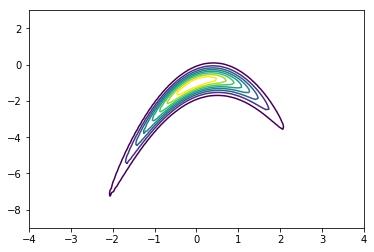

In [4]:
levels_pdf2d = np.linspace(np.min(pdf2d),np.max(pdf2d),10)
plt.figure()
plt.contour(xx, yy, pdf2d, levels=levels_pdf2d);

Let us define also the exact transport map $T^\star = B \circ L$ that we are seeking.

In [5]:
lin_tm = MAPS.LinearTransportMap(mu, npla.cholesky(sigma2))
ban_tm = MAPS.FrozenBananaMap(a, b)
Tstar = MAPS.CompositeTransportMap(ban_tm, lin_tm)

2018-08-01 15:15:49 WARNING:TM.TransportMaps: TransportMaps.Maps.CompositeTransportMaps DEPRECATED since v2.0. Use TransportMaps.Maps.CompositeMap instead


In [6]:
x1 = np.linspace(-7, 7, ndiscr)
X1d = np.vstack( (x1, np.zeros(ndiscr)) ).T
t1 = Tstar(X1d)[:,0]
t2 = ban_tm(lin_tm(X2d))[:,1]

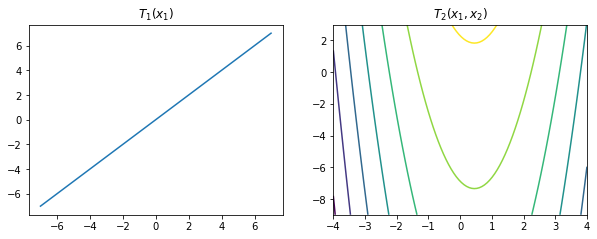

In [7]:
plt.figure(figsize=(10,3.5))
plt.subplot(121); plt.title(r"$T_1(x_1)$");
plt.plot(x1, t1);
plt.subplot(122); plt.title(r"$T_2(x_1,x_2)$");
plt.contour(xx, yy, t2.reshape(xx.shape));

## Integrated squared parametrization

The triangular transport map $T$, in the $2$ dimensional case, takes the form:

$$
T({\bf a};{\bf x}) = \left[ \begin{array}{l} 
T_1({\bf a}_1;x_1) \\
T_2({\bf a}_2;x_1,x_2)
\end{array}\right] \;. 
$$

Each of these components are parameterized by

$$
T_k({\bf a};{\bf x}) = c({\bf a}_c;{\bf x}) + \int_0^{x_k} \left( h\left({\bf a}_e;x_1,\ldots,x_{k-1},t\right) \right)^2 \, dt \;, 
$$

where $c$ and $h$ are themselves two parametric approximations. 

We use polynomial approximations for both of these functions, such that:

$$
c({\bf a}_c,{\bf x}) = \Phi_c({\bf x}) {\bf a}_c \quad \text{and} \quad h({\bf a}_e,{\bf x}) = \Phi_e(x_1,\ldots,x_{k-1},t) {\bf a}_e \;.
$$

Let's build a 2-nd order approximation of the transport map...

In [8]:
order = 2
T = TM.Default_IsotropicIntegratedSquaredTriangularTransportMap(
    2, order, 'full')

... select the reference distribution $\nu_\rho$ ...

In [9]:
rho = DIST.StandardNormalDistribution(2)

... construct the pushforward object $T_{\sharp}\nu_\rho$ ...

In [10]:
push_rho = DIST.PushForwardTransportMapDistribution(T, rho)

We are then ready to set up and solve the problem

$$
\hat{T} = \arg\min_{T \in \mathcal{T}} \mathcal{D}_{\rm KL}\left( T_\sharp \nu_\rho \Vert \nu_\pi \right) \;.
$$

In [11]:
qtype = 3           # Gauss quadrature
qparams = [10] * 2  # Quadrature order
reg = None          # No regularization
tol = 1e-5         # Optimization tolerance
ders = 2            # Use gradient and Hessian 
log = push_rho.minimize_kl_divergence(
    pi, qtype=qtype, qparams=qparams, regularization=reg,
    tol=tol, ders=ders)

Let's check the PDF approximation against the exact Banana distribution...

In [ ]:
approx_pdf = push_rho.pdf(X2d).reshape(xx.shape)
plt.figure()
plt.contour(xx, yy, pdf2d, levels=levels_pdf2d);
plt.contour(xx, yy, approx_pdf, linestyles='dashed', levels=levels_pdf2d);

and compare the approximated transport map with the exact transport map...

In [ ]:
t1_approx = T(X1d)[:,0]
t2_approx = T(X2d)[:,1]
plt.figure(figsize=(10,3.5))
plt.subplot(121); plt.title(r"$T_1(x_1)$")
plt.plot(x1, t1, 'k');
plt.plot(x1, t1_approx, 'r');
plt.subplot(122); plt.title(r"$T_2(x_1,x_2)$");
plt.contour(xx, yy, t2.reshape(xx.shape));
plt.contour(xx, yy, t2_approx.reshape(xx.shape), 
            linestyles='dashed');

## Sampling from the approximation

### Monte-Carlo sampling

In [ ]:
M = 1000
samples = push_rho.rvs(M)
plt.figure()
plt.contour(xx, yy, pdf2d);
plt.scatter(samples[:,0], samples[:,1], c='k', s=1.);

### Gauss quadratures

In [ ]:
(xq,wq) = push_rho.quadrature(qtype=3, qparams=[2,2])
plt.figure()
plt.contour(xx, yy, pdf2d);
plt.scatter(xq[:,0], xq[:,1], c='k', s=50.*wq+10.);